# Microstate stats and their analysis

Analysis of microstate stats such as average lifespan, coverage, frequency of occurrence, and transition probabilities.

In [1]:
%matplotlib inline

import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from IPython.display import display

from src.helpers import PLOTS_ROOT, RESULTS_ROOT, make_dirs

plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")
plt.rcParams["legend.frameon"] = False

WORKING_DIR = os.path.join(RESULTS_ROOT, "microstates")
PLOTTING_DIR = os.path.join(PLOTS_ROOT, "microstates")
if not os.path.exists(PLOTTING_DIR):
    make_dirs(PLOTTING_DIR)

# if True, will save all statistical tests as csv and all plots as eps
SAVE_RESULTS = True
PLOT_EXT = ".eps"
# which correction for multiple comparisons should be used
MULTI_CORRECTION = "fdr_by"

In [2]:
# load data computed with `1-main_gfp_stats_and_ideal_no_mstates.py`
df = pd.read_csv(os.path.join(WORKING_DIR, "ms_stats_run2.csv"), index_col=[0])
# divide session into PLA/PSI and time for plotting purposes
df[["condition", "time"]] = df["session"].str.split("-", expand=True)
# divide to filters
df_220 = df[df["ms_opts"] == "(2.0, 20.0, 4)"]
df_220 = df_220.sort_values(by=["condition", "time"])
df_140 = df[df["ms_opts"] == "(1.0, 40.0, 3)"]
df_140 = df_140.sort_values(by=["condition", "time"])

In [3]:
# Functions for computing, saving and displaying ANOVAs and posthoc tests


def diff_between_microstates(df, dv, filt_str):
    df = df.copy()
    print("==========")
    print(f"Microstate differences: {dv}")
    print("==========")
    anova = pg.anova(data=df, dv=dv, between=["microstate"], detailed=False)
    if SAVE_RESULTS:
        anova.round(5).to_csv(
            os.path.join(WORKING_DIR, f"{dv}_{filt_str}filt_microstate_anova.csv")
        )
    print("ANOVA")
    display(anova)
    posthoc = pg.pairwise_tukey(data=df, dv=dv, between="microstate", effsize="cohen")
    if SAVE_RESULTS:
        posthoc.round(5).to_csv(
            os.path.join(WORKING_DIR, f"{dv}_{filt_str}filt_microstate_posthoc.csv")
        )
    print("Tukey HSD")
    display(posthoc)
    
    print("==========")
    print(f"Microstate differences w.r.t condition: {dv}")
    print("==========")
    posthoc = pg.pairwise_ttests(
        data=df,
        dv=dv,
        between=["microstate"],
        within=["condition"],
        padjust=MULTI_CORRECTION,
        effsize="cohen",
        subject="subject",
        within_first=False,
    )
    display(posthoc[posthoc["p-corr"] <= 0.05])


def diff_between_time(df, dv, filt_str):
    df = df.copy()
    print("==========")
    print(f"Time differences: {dv}")
    print("==========")
    anova = pg.rm_anova(data=df, dv=dv, within=["time", "condition"], subject="subject")
    if SAVE_RESULTS:
        anova.round(5).to_csv(
            os.path.join(WORKING_DIR, f"{dv}_{filt_str}filt_time_anova.csv")
        )
    print("RM ANOVA")
    display(anova)

    posthoc = pg.pairwise_ttests(
        data=df,
        dv=dv,
        within=["time", "condition"],
        subject="subject",
        effsize="cohen",
        padjust=MULTI_CORRECTION,
        return_desc=True,
    )
    if SAVE_RESULTS:
        posthoc.round(5).to_csv(
            os.path.join(WORKING_DIR, f"{dv}_{filt_str}filt_time_cond_posthoc.csv")
        )
    print(
        f"Pairwise 'time x condition' t-tests (showing only significant after {MULTI_CORRECTION.upper()} correction < 0.05)"
    )
    display(posthoc[posthoc["p-corr"] <= 0.05])

    posthoc = pg.pairwise_ttests(
        data=df,
        dv=dv,
        within=["condition", "time"],
        subject="subject",
        effsize="cohen",
        padjust=MULTI_CORRECTION,
        return_desc=True,
    )
    if SAVE_RESULTS:
        posthoc.round(5).to_csv(
            os.path.join(WORKING_DIR, f"{dv}_{filt_str}filt_cond_time_posthoc.csv")
        )
    print(
        f"Pairwise 'condition x time' t-tests (showing only significant after {MULTI_CORRECTION.upper()} correction < 0.05)"
    )
    display(posthoc[posthoc["p-corr"] <= 0.05])


def diff_between_time_and_microstates(df, dv, filt_str):
    df = df.copy()
    print("==========")
    print(f"Time differences: {dv}")
    print("==========")
    for ms in np.unique(df["microstate"]):
        print("----------")
        print(f"microstate {ms}")
        print("----------")
        anova = pg.rm_anova(
            data=df[df["microstate"] == ms],
            dv=dv,
            within=["time", "condition"],
            subject="subject",
        )
        if SAVE_RESULTS:
            anova.round(5).to_csv(
                os.path.join(
                    WORKING_DIR, f"{dv}_microstate{ms}_{filt_str}filt_anova.csv"
                )
            )
        print("RM ANOVA")
        display(anova)

        posthoc = pg.pairwise_ttests(
            data=df[df["microstate"] == ms],
            dv=dv,
            within=["time", "condition"],
            subject="subject",
            effsize="cohen",
            padjust=MULTI_CORRECTION,
            return_desc=True,
        )
        if SAVE_RESULTS:
            posthoc.round(5).to_csv(
                os.path.join(
                    WORKING_DIR,
                    f"{dv}_microstate{ms}_{filt_str}filt_time_cond_posthoc.csv",
                )
            )
        print(
            f"Pairwise 'time x condition' t-tests (showing only significant after {MULTI_CORRECTION.upper()} correction < 0.05)"
        )
        display(posthoc[posthoc["p-corr"] <= 0.05])

        posthoc = pg.pairwise_ttests(
            data=df[df["microstate"] == ms],
            dv=dv,
            within=["condition", "time"],
            subject="subject",
            effsize="cohen",
            padjust=MULTI_CORRECTION,
            return_desc=True,
        )
        if SAVE_RESULTS:
            posthoc.round(5).to_csv(
                os.path.join(
                    WORKING_DIR,
                    f"{dv}_microstate{ms}_{filt_str}filt_cond_time_posthoc.csv",
                )
            )
        print(
            f"Pairwise 'condition x time' t-tests (showing only significant after {MULTI_CORRECTION.upper()} correction < 0.05)"
        )
        display(posthoc[posthoc["p-corr"] <= 0.05])

In [4]:
## Functions for plotting and saving boxplots


def _plot_ttest_signi(
    where, df_for_max, ax, plot_for="time", x1_base=-0.2, x2_base=0.2
):
    y = df_for_max.max() * 1.02
    h = df_for_max.max() * 0.05
    col = plt.rcParams["text.color"]
    for _, row in where.iterrows():
        if plot_for == "time":
            pos = int(row["time"][-1]) - 1
        elif plot_for == "microstate":
            pos = string.ascii_uppercase.index(row["microstate"])
        else:
            raise ValueError(f"Unkown for: {plot_for}")
        x1, x2 = x1_base + pos, x2_base + pos
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        if row["p-corr"] < 0.001:
            text = "p < 0.000"
        else:
            text = f"p={row['p-corr']:.3f}"
        ax.text(
            (x1 + x2) * 0.5,
            y + h,
            text,
            ha="center",
            va="bottom",
            color=col,
        )


def plot_boxes(df, dv, filt_str, plot_signi=True):
    # individual "factors"
    _, axs = plt.subplots(1, 2, sharey=True)
    sns.boxplot(x="microstate", y=dv, data=df, hue="condition", ax=axs[0])
    sns.despine(trim=True)
    if plot_signi:
        sign = pg.pairwise_ttests(
            data=df,
            dv=dv,
            between=["microstate"],
            within=["condition"],
            padjust=MULTI_CORRECTION,
            subject="subject",
            within_first=False,
        )
        # find significant
        where = sign[
            (sign["p-corr"] <= 0.05) & (sign["Contrast"] == "microstate * condition")
        ]
        _plot_ttest_signi(
            where, df[dv], ax=axs[0], plot_for="microstate", x1_base=-0.2, x2_base=0.2
        )

    sns.boxplot(x="time", y=dv, data=df, hue="condition", ax=axs[1])
    sns.despine(trim=True)
    if plot_signi:
        sign = pg.pairwise_ttests(
            data=df,
            dv=dv,
            within=["time", "condition"],
            subject="subject",
            padjust=MULTI_CORRECTION,
        )
        # find significant
        where = sign[
            (sign["p-corr"] <= 0.05) & (sign["Contrast"] == "time * condition")
        ]
        _plot_ttest_signi(
            where, df[dv], ax=axs[1], plot_for="time", x1_base=-0.2, x2_base=0.2
        )
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(
                PLOTTING_DIR, f"{dv}_boxplot_factors_{filt_str}filt{PLOT_EXT}"
            ),
            bbox_inches="tight",
            transparent=True,
        )
    else:
        plt.show()

    # interaction
    _, axs = plt.subplots(1, len(np.unique(df["microstate"])), sharex=True, sharey=True)
    for i, ms in enumerate(np.unique(df["microstate"])):
        ax = axs[i]
        sns.boxplot(
            x="time",
            y=dv,
            data=df[df["microstate"] == ms],
            hue="condition",
            ax=ax,
        )
        ax.set_title(f"Microstate {ms}")
        sns.despine(trim=True)
        if plot_signi:
            sign = pg.pairwise_ttests(
                data=df[df["microstate"] == ms],
                dv=dv,
                within=["time", "condition"],
                subject="subject",
                padjust=MULTI_CORRECTION,
            )
            # find significant
            where = sign[
                (sign["p-corr"] <= 0.05) & (sign["Contrast"] == "time * condition")
            ]
            _plot_ttest_signi(
                where,
                df[df["microstate"] == ms][dv],
                ax=ax,
                plot_for="time",
                x1_base=-0.2,
                x2_base=0.2,
            )
        plt.tight_layout()
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(
                PLOTTING_DIR, f"{dv}_boxplot_interaction_{filt_str}filt{PLOT_EXT}"
            ),
            bbox_inches="tight",
            transparent=True,
        )
    else:
        plt.show()

## Explained variance

In [5]:
# 2-20Hz
pg.rm_anova(
    data=df_220.drop_duplicates(subset=["subject", "session"]),
    dv="var_GFP",
    within=["condition", "time"],
    subject="subject",
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,condition,0.014638,1,14,0.014638,4.225659,0.058965,0.058965,0.231852,1.000000
1,time,0.008588,4,56,0.002147,2.041950,0.100864,0.126709,0.127288,0.707324
2,condition * time,0.011821,4,56,0.002955,1.962992,0.112741,0.145875,0.122971,0.629870


In [6]:
# 1-40Hz
pg.rm_anova(
    data=df_140.drop_duplicates(subset=["subject", "session"]),
    dv="var_GFP",
    within=["condition", "time"],
    subject="subject",
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,condition,0.023459,1,14,0.023459,5.674647,0.031941,0.031941,0.288424,1.000000
1,time,0.012773,4,56,0.003193,2.521258,0.051102,0.073663,0.152607,0.719554
2,condition * time,0.020680,4,56,0.005170,2.750580,0.036878,0.065994,0.164208,0.629664


## Average lifespan ~ 2-20Hz filter ~ 4 microstates

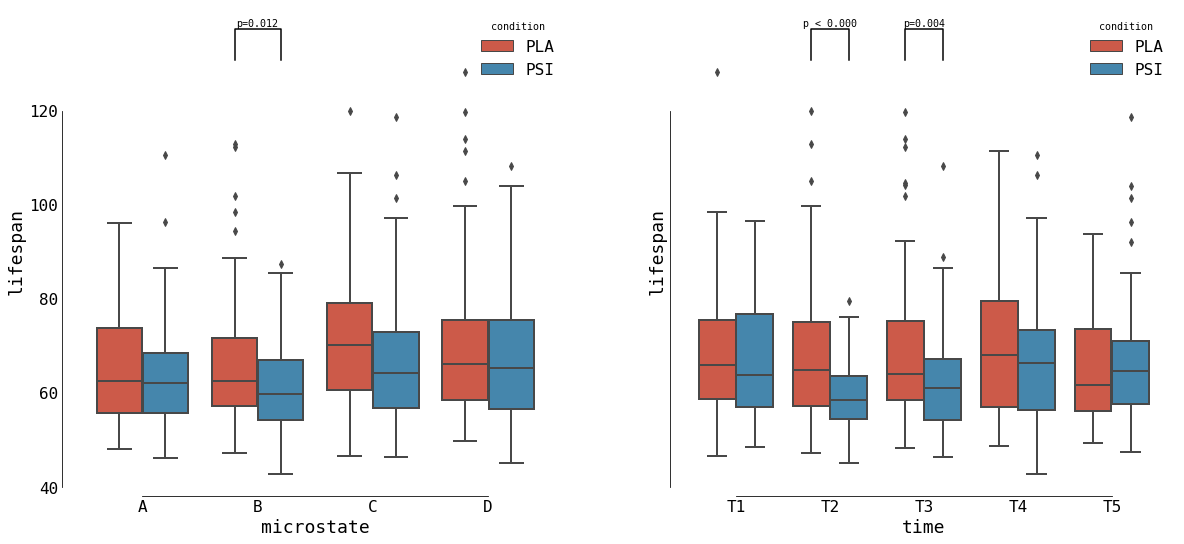

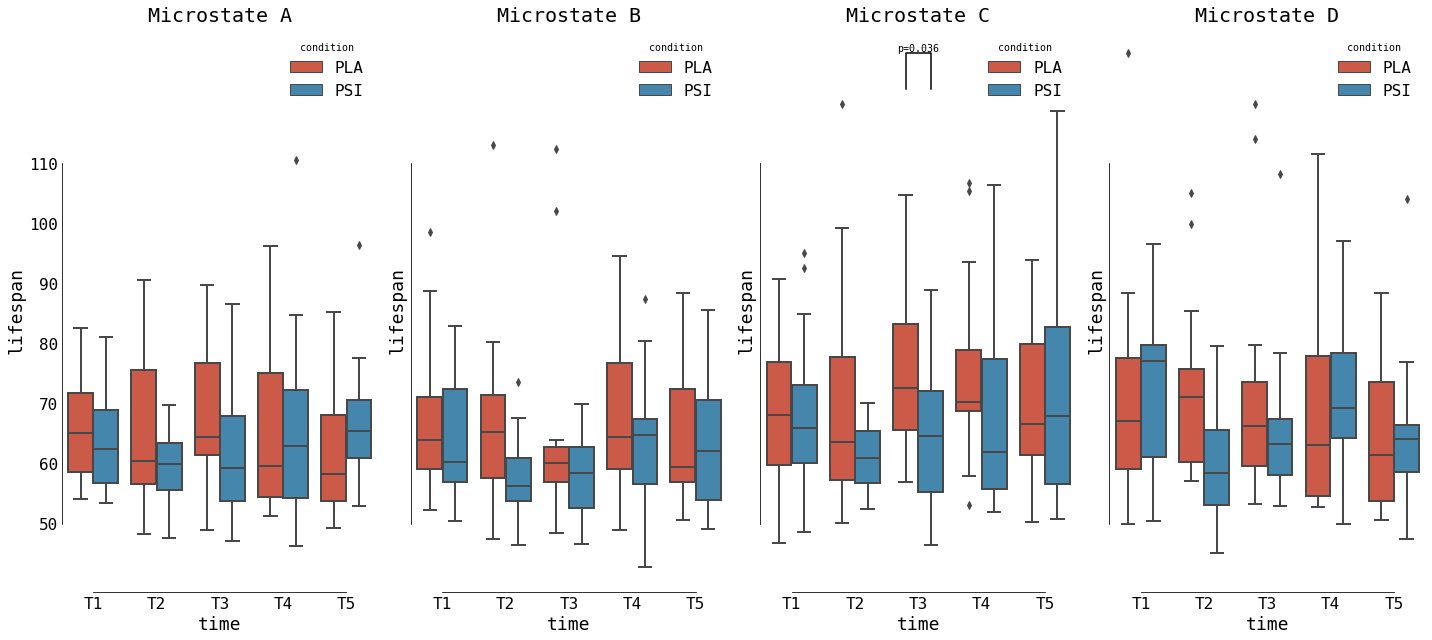

In [7]:
plot_boxes(df_220, "lifespan", "2-20")

### Differences between microstates

In [8]:
diff_between_microstates(df_220, "lifespan", filt_str="2-20")

Microstate differences: lifespan
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,3,596,6.667808,0.000197,0.032473


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,64.330336,63.890310,0.440026,1.564717,0.281218,0.900000,0.032472
1,A,C,64.330336,69.560503,-5.230167,1.564717,-3.342564,0.004673,-0.385966
2,A,D,64.330336,68.400319,-4.069982,1.564717,-2.601098,0.046168,-0.300349
3,B,C,63.890310,69.560503,-5.670193,1.564717,-3.623782,0.001680,-0.418438
4,B,D,63.890310,68.400319,-4.510009,1.564717,-2.882316,0.020771,-0.332821
5,C,D,69.560503,68.400319,1.160184,1.564717,0.741466,0.888028,0.085617


Microstate differences w.r.t condition: lifespan


,Contrast,microstate,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
8,microstate * condition,B,PLA,PSI,True,True,3.323938,74.0,two-sided,0.001382,0.01152,fdr_by,18.499,0.418011


### Differences between times

In [9]:
diff_between_time(df_220, "lifespan", filt_str="2-20")

Time differences: lifespan
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,331.479672,4,56,82.869918,4.705520,0.002409,0.005957,0.251558,0.767948
1,condition,507.544808,1,14,507.544808,4.623779,0.049490,0.049490,0.248273,1.000000
2,time * condition,654.007021,4,56,163.501755,4.202308,0.004798,0.014155,0.230867,0.672629


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,67.787916,7.864217,64.032863,7.642963,True,True,4.451359,14.0,two-sided,0.000548,0.016050,fdr_by,64.987,0.484249
12,time * condition,T2,PLA,PSI,68.724260,15.837745,59.341466,7.248388,True,True,4.610517,59.0,two-sided,0.000022,0.000252,fdr_by,878.832,0.761831
13,time * condition,T3,PLA,PSI,70.157160,16.531358,62.587009,11.325144,True,True,3.554995,59.0,two-sided,0.000752,0.004293,fdr_by,34.644,0.534260


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,67.787916,7.864217,64.032863,7.642963,True,True,4.451359,14.0,two-sided,0.000548,0.016050,fdr_by,64.987,0.484249
19,condition * time,PLA,T3,T5,70.157160,16.531358,65.319983,11.758047,True,True,3.285092,59.0,two-sided,0.001718,0.030912,fdr_by,16.499,0.337211
21,condition * time,PSI,T1,T2,67.284929,12.336034,59.341466,7.248388,True,True,5.017030,59.0,two-sided,0.000005,0.000368,fdr_by,3415.832,0.785142
26,condition * time,PSI,T2,T4,59.341466,7.248388,67.161838,14.414768,True,True,-4.375464,59.0,two-sided,0.000050,0.001202,fdr_by,411.066,-0.685464
27,condition * time,PSI,T2,T5,59.341466,7.248388,67.154268,14.097851,True,True,-4.468123,59.0,two-sided,0.000036,0.001202,fdr_by,553.299,-0.697004


### Significance of time / condition for each microstate

In [10]:
diff_between_time_and_microstates(df_220, "lifespan", filt_str="2-20")

Time differences: lifespan
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,189.101170,4,56,47.275292,0.761493,0.554770,0.480825,0.051586,0.520065
1,condition,130.850461,1,14,130.850461,1.582651,0.228957,0.228957,0.101565,1.000000
2,time * condition,812.847828,4,56,203.211957,2.440238,0.057343,0.075060,0.148431,0.777554


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,385.950497,4,56,96.487624,1.664725,0.171062,0.193897,0.106272,0.685934
1,condition,954.045613,1,14,954.045613,5.028405,0.041645,0.041645,0.264258,1.000000
2,time * condition,263.853348,4,56,65.963337,1.064593,0.382655,0.377669,0.070669,0.833270


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,801.168317,4,56,200.292079,2.378628,0.062591,0.074620,0.145228,0.845686
1,condition,943.069137,1,14,943.069137,2.960774,0.107322,0.107322,0.174566,1.000000
2,time * condition,1097.660715,4,56,274.415179,2.834382,0.032736,0.047714,0.168369,0.772971


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
13,time * condition,T3,PLA,PSI,75.769624,15.512299,64.356749,11.550605,True,True,3.556004,14.0,two-sided,0.003163,0.036111,fdr_by,14.531,0.834539


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate D
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,951.327241,4,56,237.831810,2.180210,0.082948,0.092942,0.134745,0.876742
1,condition,291.691297,1,14,291.691297,0.951465,0.345901,0.345901,0.063637,1.000000
2,time * condition,1065.480296,4,56,266.370074,1.818534,0.138081,0.156003,0.114962,0.778548


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


## Coverage ~ 2-20Hz filter ~ 4 microstates

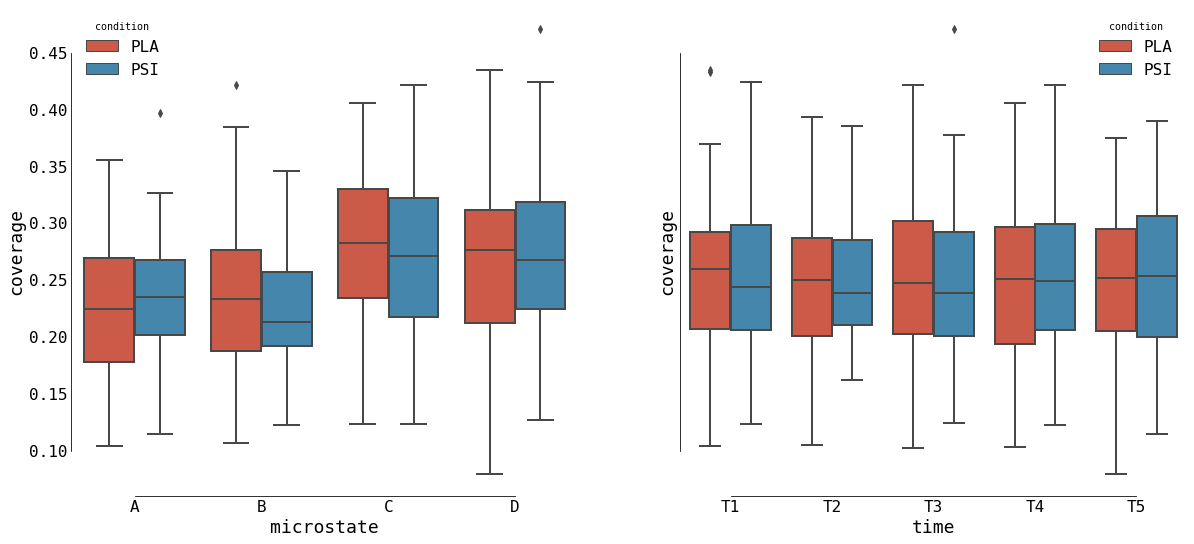

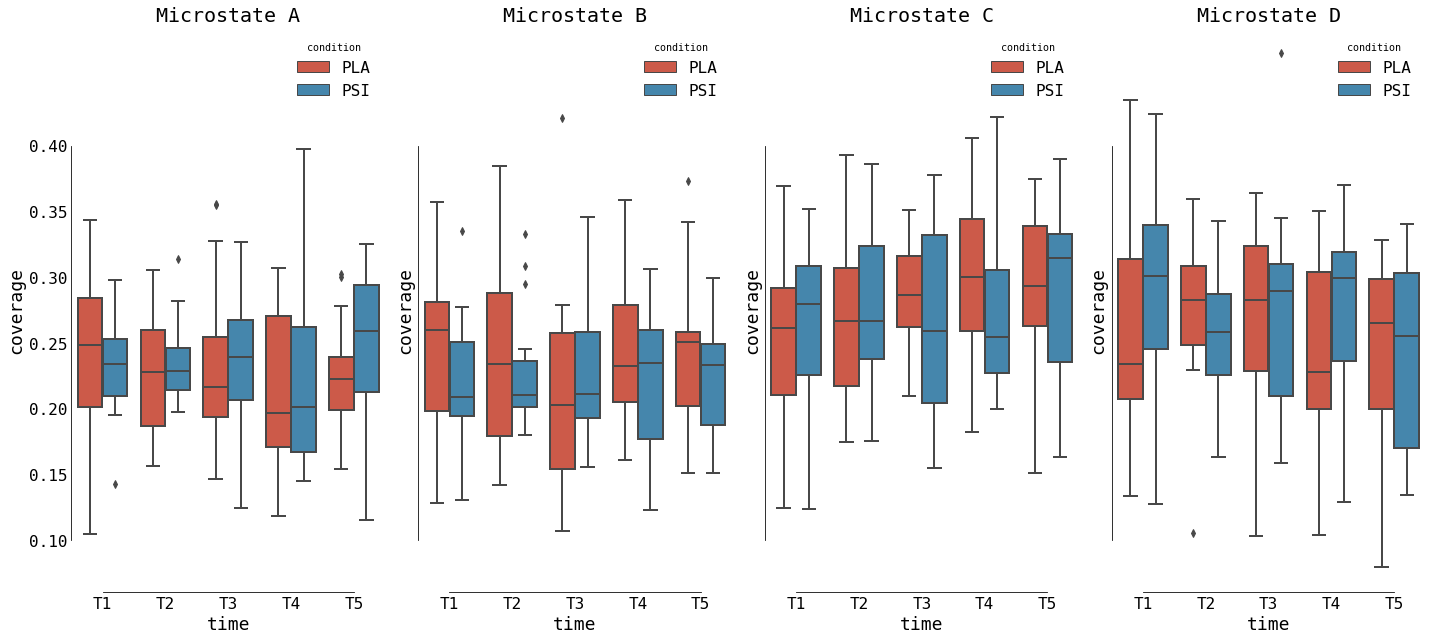

In [11]:
plot_boxes(df_220, "coverage", "2-20")

### Differences between microstates

In [12]:
diff_between_microstates(df_220, "coverage", filt_str="2-20")

Microstate differences: coverage
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,3,596,20.625355,1.000184e-12,0.094054


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,0.231072,0.229467,0.001605,0.007283,0.220330,0.900000,0.025442
1,A,C,0.231072,0.276155,-0.045083,0.007283,-6.190243,0.001000,-0.714788
2,A,D,0.231072,0.263306,-0.032234,0.007283,-4.425905,0.001000,-0.511060
3,B,C,0.229467,0.276155,-0.046688,0.007283,-6.410573,0.001000,-0.740229
4,B,D,0.229467,0.263306,-0.033838,0.007283,-4.646235,0.001000,-0.536501
5,C,D,0.276155,0.263306,0.012850,0.007283,1.764338,0.291102,0.203728


Microstate differences w.r.t condition: coverage


,Contrast,microstate,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
1,microstate,-,A,C,False,True,-6.254251,28.0,two-sided,9.258858e-07,0.000014,fdr_by,1.271e+04,-2.283729
2,microstate,-,A,D,False,True,-2.807027,28.0,two-sided,9.001382e-03,0.044107,fdr_by,5.507,-1.024981
3,microstate,-,B,C,False,True,-4.862386,28.0,two-sided,4.040354e-05,0.000297,fdr_by,455.602,-1.775492


### Differences between time

In [13]:
diff_between_time(df_220, "coverage", filt_str="2-20")

Time differences: coverage
RM ANOVA


/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/parametric.py:713: RuntimeWarning: invalid value encountered in double_scalars
  f_b = ms_b / ms_bs


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.0,4,56,0.0,0.0,1.0,1.0,0.0,0.428571
1,condition,0.0,1,14,0.0,NaN,NaN,NaN,NaN,1.000000
2,time * condition,0.0,4,56,0.0,0.0,1.0,1.0,0.0,0.564675


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


### Significance of time / condition for each microstate

In [14]:
diff_between_time_and_microstates(df_220, "coverage", filt_str="2-20")

Time differences: coverage
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.007348,4,56,0.001837,0.736704,0.570875,0.530064,0.049991,0.713418
1,condition,0.001901,1,14,0.001901,0.603792,0.450066,0.450066,0.041345,1.000000
2,time * condition,0.004963,4,56,0.001241,0.351967,0.841580,0.796155,0.024524,0.782667


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.003178,4,56,0.000794,0.277212,0.891499,0.838116,0.019416,0.736567
1,condition,0.005569,1,14,0.005569,1.248668,0.282617,0.282617,0.081887,1.000000
2,time * condition,0.005638,4,56,0.001409,0.616076,0.652863,0.607409,0.042151,0.744977


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.022046,4,56,0.005512,1.289829,0.285046,0.290829,0.084359,0.718442
1,condition,0.000552,1,14,0.000552,0.084177,0.775968,0.775968,0.005977,1.000000
2,time * condition,0.009640,4,56,0.002410,0.611219,0.656273,0.636396,0.041832,0.880712


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate D
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.017734,4,56,0.004433,1.125843,0.353642,0.349701,0.074432,0.757559
1,condition,0.002973,1,14,0.002973,0.423948,0.525517,0.525517,0.029392,1.000000
2,time * condition,0.013357,4,56,0.003339,0.922507,0.457435,0.444892,0.061820,0.827047


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


## Frequency of occurrence ~ 2-20Hz filter ~ 4 microstates

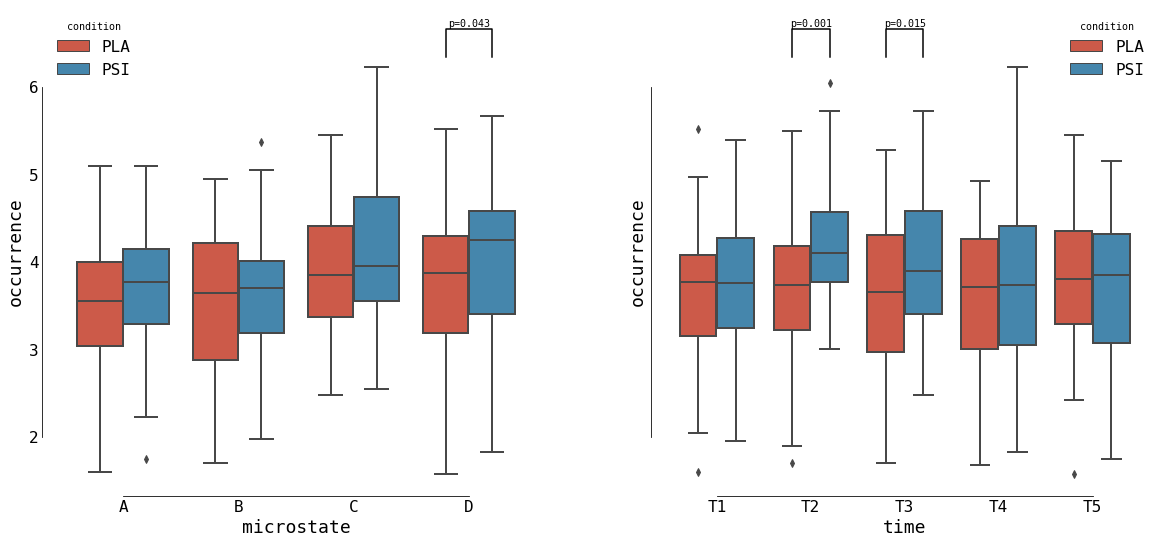

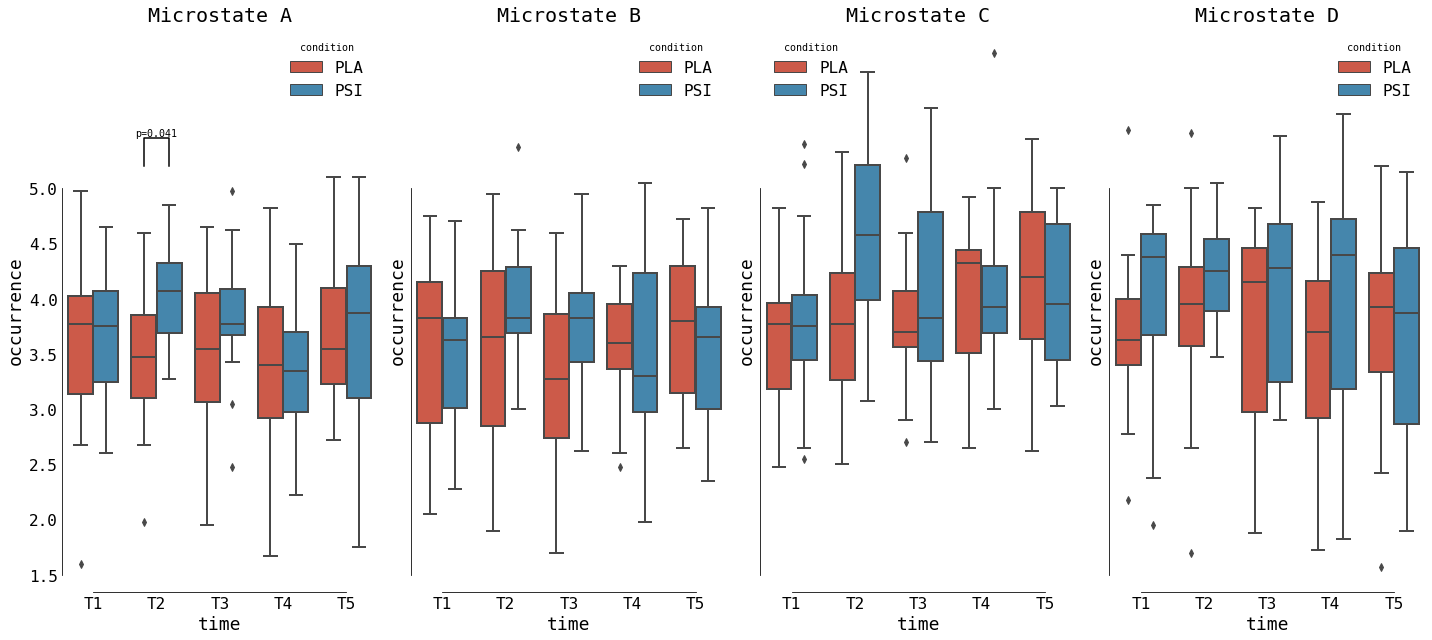

In [15]:
plot_boxes(df_220, "occurrence", "2-20")

### Differences between microstates

In [16]:
diff_between_microstates(df_220, "occurrence", filt_str="2-20")

Microstate differences: occurrence
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,3,596,9.31112,0.000005,0.04477


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,3.612647,3.600648,0.011999,0.091656,0.130912,0.900000,0.015116
1,A,C,3.612647,4.002109,-0.389462,0.091656,-4.249175,0.001000,-0.490652
2,A,D,3.612647,3.870122,-0.257475,0.091656,-2.809147,0.025780,-0.324372
3,B,C,3.600648,4.002109,-0.401461,0.091656,-4.380087,0.001000,-0.505769
4,B,D,3.600648,3.870122,-0.269474,0.091656,-2.940058,0.017442,-0.339489
5,C,D,4.002109,3.870122,0.131987,0.091656,1.440029,0.475157,0.166280


Microstate differences w.r.t condition: occurrence


,Contrast,microstate,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
10,microstate * condition,D,PLA,PSI,True,True,-2.882252,74.0,two-sided,0.005165,0.043042,fdr_by,5.717,-0.327821


### Differences between time

In [17]:
diff_between_time(df_220, "occurrence", filt_str="2-20")

Time differences: occurrence
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,1.325532,4,56,0.331383,5.645539,0.000687,0.002293,0.287370,0.760376
1,condition,1.580758,1,14,1.580758,6.093352,0.027064,0.027064,0.303252,1.000000
2,time * condition,1.743968,4,56,0.435992,4.576209,0.002873,0.008016,0.246348,0.726387


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,3.681099,0.416808,3.941073,0.419985,True,True,-5.119480,14.0,two-sided,0.000156,0.004569,fdr_by,193.972,-0.621354
12,time * condition,T2,PLA,PSI,3.684224,0.830812,4.197923,0.654562,True,True,-4.111700,59.0,two-sided,0.000123,0.001407,fdr_by,179.683,-0.686859
13,time * condition,T3,PLA,PSI,3.579650,0.831496,3.962113,0.762247,True,True,-3.139725,59.0,two-sided,0.002641,0.015078,fdr_by,11.253,-0.479503


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,3.681099,0.416808,3.941073,0.419985,True,True,-5.119480,14.0,two-sided,0.000156,0.004569,fdr_by,193.972,-0.621354
21,condition * time,PSI,T1,T2,3.720053,0.760619,4.197923,0.654562,True,True,-4.733990,59.0,two-sided,0.000014,0.001023,fdr_by,1320.073,-0.673460
26,condition * time,PSI,T2,T4,4.197923,0.654562,3.756300,0.896077,True,True,3.943838,59.0,two-sided,0.000216,0.005400,fdr_by,107.735,0.562816
27,condition * time,PSI,T2,T5,4.197923,0.654562,3.733802,0.844278,True,True,3.930547,59.0,two-sided,0.000225,0.005400,fdr_by,103.515,0.614405


### Significance of time / condition for each microstate

In [18]:
diff_between_time_and_microstates(df_220, "occurrence", filt_str="2-20")

Time differences: occurrence
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,2.504286,4,56,0.626071,2.044092,0.100560,0.123880,0.127405,0.733141
1,condition,1.550114,1,14,1.550114,2.506134,0.135726,0.135726,0.151830,1.000000
2,time * condition,1.747867,4,56,0.436967,1.131446,0.351082,0.347390,0.074774,0.753171


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
12,time * condition,T2,PLA,PSI,3.457996,0.700357,4.004609,0.471577,True,True,-3.49428,14.0,two-sided,0.003576,0.040822,fdr_by,13.106,-0.915557


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,1.238275,4,56,0.309569,0.820603,0.517532,0.491383,0.055369,0.762090
1,condition,0.395189,1,14,0.395189,0.748157,0.401639,0.401639,0.050729,1.000000
2,time * condition,3.184361,4,56,0.796090,2.168089,0.084385,0.104040,0.134097,0.770578


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,3.794467,4,56,0.948617,2.752478,0.036779,0.054679,0.164303,0.746841
1,condition,1.931960,1,14,1.931960,2.646364,0.126077,0.126077,0.158976,1.000000
2,time * condition,3.676424,4,56,0.919106,1.772377,0.147278,0.159861,0.112372,0.838079


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate D
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,2.096740,4,56,0.524185,1.604511,0.185912,0.209931,0.102824,0.642181
1,condition,3.116995,1,14,3.116995,5.647681,0.032289,0.032289,0.287448,1.000000
2,time * condition,1.321409,4,56,0.330352,0.988375,0.421457,0.401719,0.065943,0.671963


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


## Average lifespan ~ 1-40Hz filter ~ 3 microstates

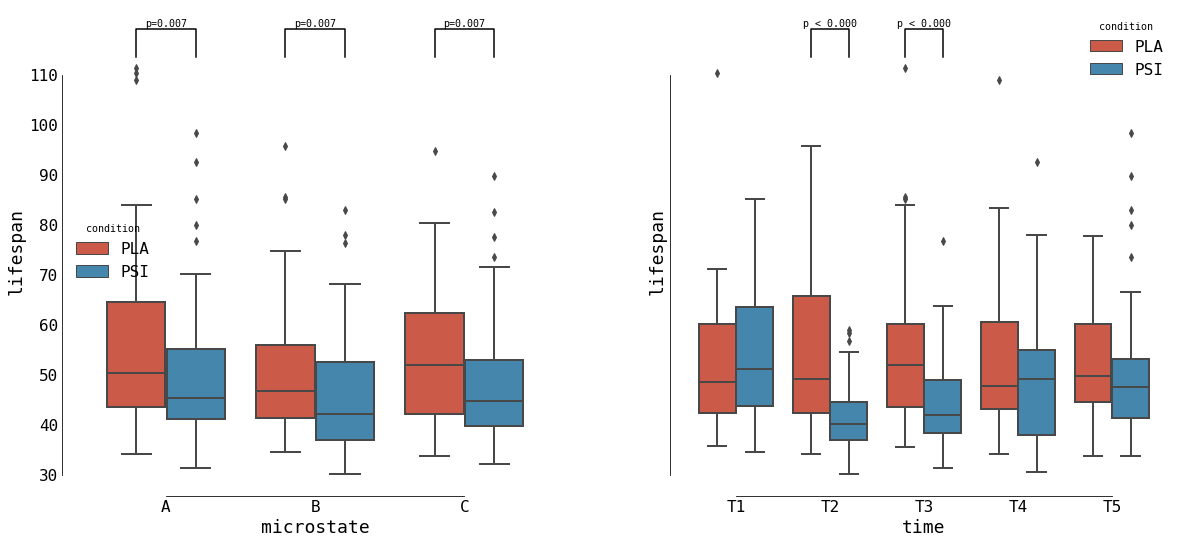

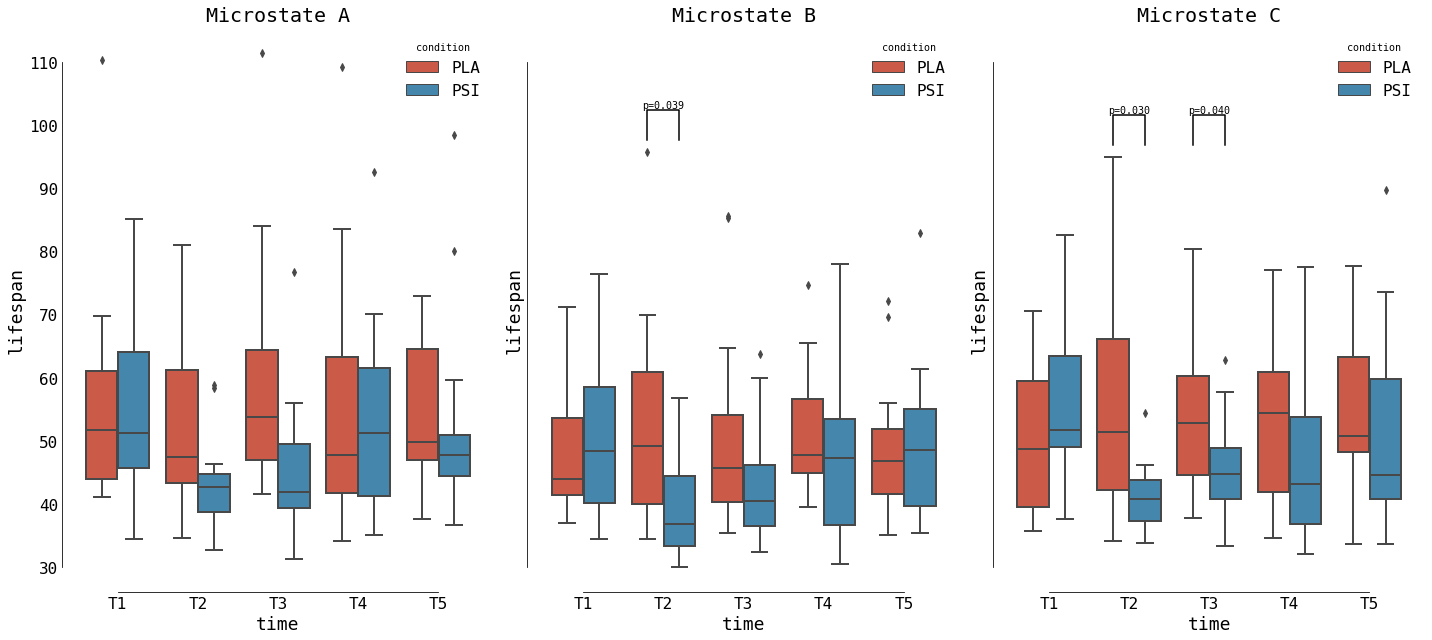

In [19]:
plot_boxes(df_140, "lifespan", "1-40")

### Differences between microstates

In [20]:
diff_between_microstates(df_140, "lifespan", filt_str="1-40")

Microstate differences: lifespan
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,2,447,3.974533,0.019456,0.017472


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,52.706067,48.243083,4.462985,1.594286,2.799363,0.014273,0.323243
1,A,C,52.706067,50.937946,1.768121,1.594286,1.109037,0.528592,0.128061
2,B,C,48.243083,50.937946,-2.694864,1.594286,-1.690327,0.209302,-0.195182


Microstate differences w.r.t condition: lifespan


,Contrast,microstate,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
4,microstate * condition,A,PLA,PSI,True,True,3.100529,74.0,two-sided,0.002733,0.006564,fdr_by,10.05,0.407495
5,microstate * condition,B,PLA,PSI,True,True,3.009094,74.0,two-sided,0.003581,0.006564,fdr_by,7.904,0.376320
6,microstate * condition,C,PLA,PSI,True,True,3.303901,74.0,two-sided,0.001471,0.006564,fdr_by,17.491,0.426540


### Differences between time

In [21]:
diff_between_time(df_140, "lifespan", filt_str="1-40")

Time differences: lifespan
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,471.620578,4,56,117.905144,6.012335,0.000426,0.004185,0.300431,0.584555
1,condition,1118.017848,1,14,1118.017848,13.626272,0.002418,0.002418,0.493236,1.000000
2,time * condition,1069.164081,4,56,267.291020,7.183976,0.000096,0.001714,0.339123,0.581511


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,52.693725,9.504282,47.662210,8.025613,True,True,5.203165,14.0,two-sided,0.000134,0.003919,fdr_by,221.893,0.572018
12,time * condition,T2,PLA,PSI,53.852403,15.532873,41.472017,7.235971,True,True,5.539314,44.0,two-sided,0.000002,0.000018,fdr_by,1.079e+04,1.021761
13,time * condition,T3,PLA,PSI,55.078903,16.056090,44.321317,9.596556,True,True,4.611397,44.0,two-sided,0.000034,0.000196,fdr_by,627.364,0.813323


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,52.693725,9.504282,47.662210,8.025613,True,True,5.203165,14.0,two-sided,1.338090e-04,0.003919,fdr_by,221.893,0.572018
21,condition * time,PSI,T1,T2,53.457690,12.889847,41.472017,7.235971,True,True,6.338613,44.0,two-sided,1.071842e-07,0.000008,fdr_by,1.356e+05,1.146685
22,condition * time,PSI,T1,T3,53.457690,12.889847,44.321317,9.596556,True,True,5.594042,44.0,two-sided,1.328297e-06,0.000048,fdr_by,1.281e+04,0.804036
26,condition * time,PSI,T2,T4,41.472017,7.235971,49.164951,13.970765,True,True,-3.634113,44.0,two-sided,7.259441e-04,0.013059,fdr_by,39.224,-0.691485
27,condition * time,PSI,T2,T5,41.472017,7.235971,51.078678,14.621805,True,True,-3.850340,44.0,two-sided,3.784206e-04,0.009076,fdr_by,70.484,-0.832758


### Significance of time / condition for each microstate

In [22]:
diff_between_time_and_microstates(df_140, "lifespan", filt_str="1-40")

Time differences: lifespan
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,853.873154,4,56,213.468289,2.302268,0.069762,0.097520,0.141224,0.684181
1,condition,1459.138844,1,14,1459.138844,5.247740,0.038008,0.038008,0.272642,1.000000
2,time * condition,962.431227,4,56,240.607807,2.112963,0.091234,0.133341,0.131134,0.555847


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,270.972577,4,56,67.743144,1.055506,0.387123,0.374403,0.070108,0.676978
1,condition,805.962909,1,14,805.962909,9.761439,0.007463,0.007463,0.410810,1.000000
2,time * condition,1154.952092,4,56,288.738023,3.781470,0.008605,0.014205,0.212664,0.819597


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
12,time * condition,T2,PLA,PSI,52.776137,16.332744,39.982516,8.847497,True,True,3.520277,14.0,two-sided,0.003396,0.038766,fdr_by,13.688,0.974038


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,549.829653,4,56,137.457413,1.899379,0.123289,0.130032,0.119462,0.915684
1,condition,1137.184064,1,14,1137.184064,10.294062,0.006314,0.006314,0.423727,1.000000
2,time * condition,1502.907455,4,56,375.726864,4.515463,0.003121,0.008510,0.243875,0.727196


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
12,time * condition,T2,PLA,PSI,55.314454,16.326652,40.951666,5.329619,True,True,3.649077,14.0,two-sided,0.002630,0.030022,fdr_by,16.982,1.182685
13,time * condition,T3,PLA,PSI,54.943097,12.897588,45.446951,7.958382,True,True,3.159201,14.0,two-sided,0.006963,0.039748,fdr_by,7.51,0.886130


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
21,condition * time,PSI,T1,T2,55.474624,12.717331,40.951666,5.329619,True,True,4.209571,14.0,two-sided,0.000874,0.031449,fdr_by,43.448,1.489494
22,condition * time,PSI,T1,T3,55.474624,12.717331,45.446951,7.958382,True,True,4.532594,14.0,two-sided,0.000469,0.031449,fdr_by,74.351,0.945279


## Coverage ~ 1-40Hz filter ~ 3 microstates

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/parametric.py:215: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")


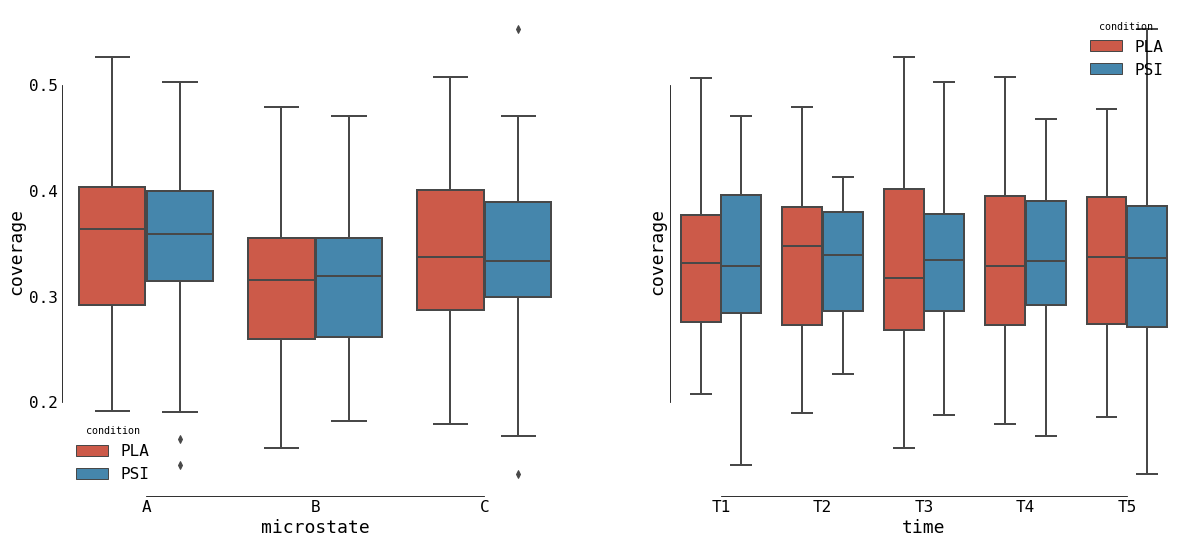

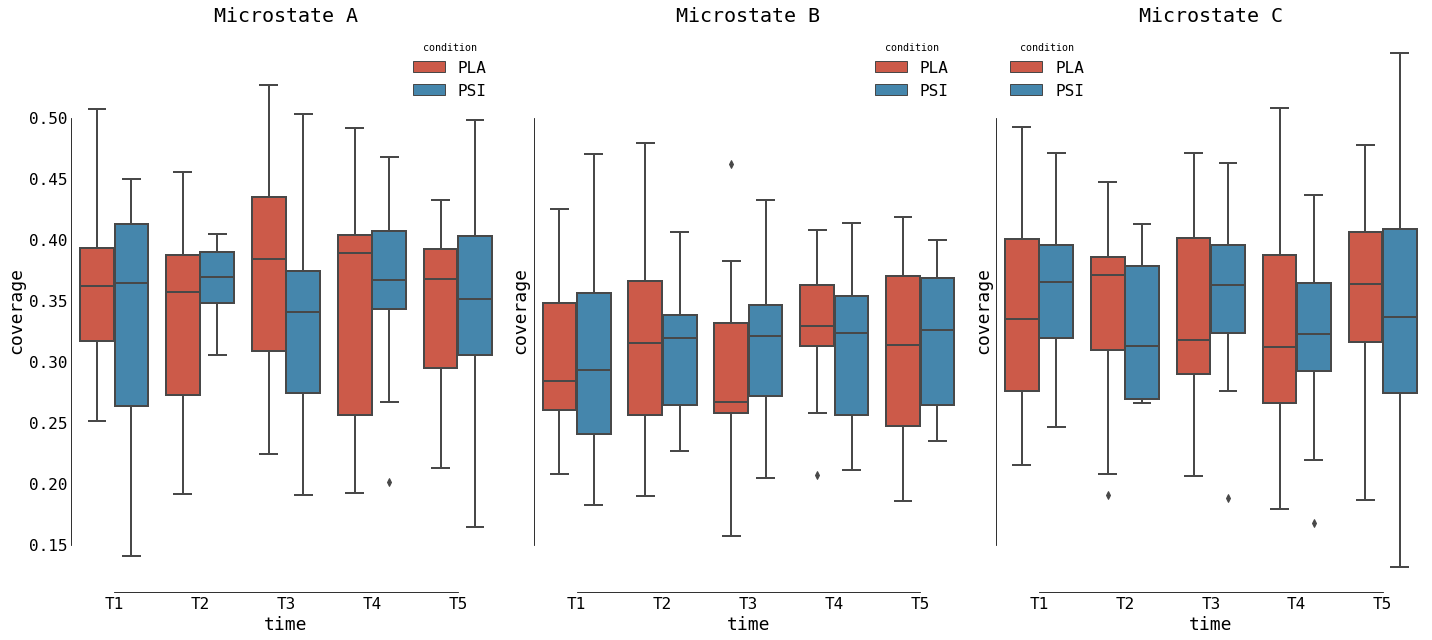

In [23]:
plot_boxes(df_140, "coverage", "1-40")

### Differences between microstates

In [24]:
diff_between_microstates(df_140, "coverage", filt_str="1-40")

Microstate differences: coverage
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,2,447,10.493505,0.000035,0.044845


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,0.348362,0.311138,0.037224,0.008565,4.34589,0.001000,0.501820
1,A,C,0.348362,0.340500,0.007862,0.008565,0.91788,0.693319,0.105988
2,B,C,0.311138,0.340500,-0.029362,0.008565,-3.42801,0.001781,-0.395832


Microstate differences w.r.t condition: coverage


,Contrast,microstate,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,microstate,-,A,B,False,True,3.159540,28.0,two-sided,0.003771,0.018899,fdr_by,10.739,1.153701
2,microstate,-,B,C,False,True,-2.918077,28.0,two-sided,0.006872,0.018899,fdr_by,6.758,-1.065531


### Differences between time

In [25]:
diff_between_time(df_140, "coverage", filt_str="1-40")

Time differences: coverage
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,4.622232e-31,4,56,1.155558e-31,-3.608247,1.0,1.0,-0.347222,0.298174
1,condition,7.395571e-30,1,14,7.395571e-30,-11.914894,1.0,1.0,-5.714286,1.000000
2,time * condition,-7.811572e-30,4,56,-1.952893e-30,-11.985816,1.0,1.0,-5.950704,0.421419


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/parametric.py:215: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/parametric.py:215: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


### Significance of time / condition for each microstate

In [26]:
diff_between_time_and_microstates(df_140, "coverage", filt_str="1-40")

Time differences: coverage
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.002740,4,56,0.000685,0.118313,0.975456,0.944191,0.008380,0.721054
1,condition,0.000046,1,14,0.000046,0.007530,0.932077,0.932077,0.000538,1.000000
2,time * condition,0.035734,4,56,0.008933,1.668763,0.170107,0.198628,0.106503,0.611447


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.006839,4,56,0.001710,0.447444,0.773786,0.737428,0.030970,0.821393
1,condition,0.000002,1,14,0.000002,0.000539,0.981809,0.981809,0.000038,1.000000
2,time * condition,0.009087,4,56,0.002272,0.495783,0.738845,0.693157,0.034202,0.775340


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,0.012209,4,56,0.003052,0.480757,0.749713,0.735078,0.033200,0.922241
1,condition,0.000064,1,14,0.000064,0.006239,0.938160,0.938160,0.000445,1.000000
2,time * condition,0.014197,4,56,0.003549,0.694408,0.598977,0.552917,0.047257,0.707217


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


## Frequency of occurrence ~ 1-40Hz filter ~ 3 microstates

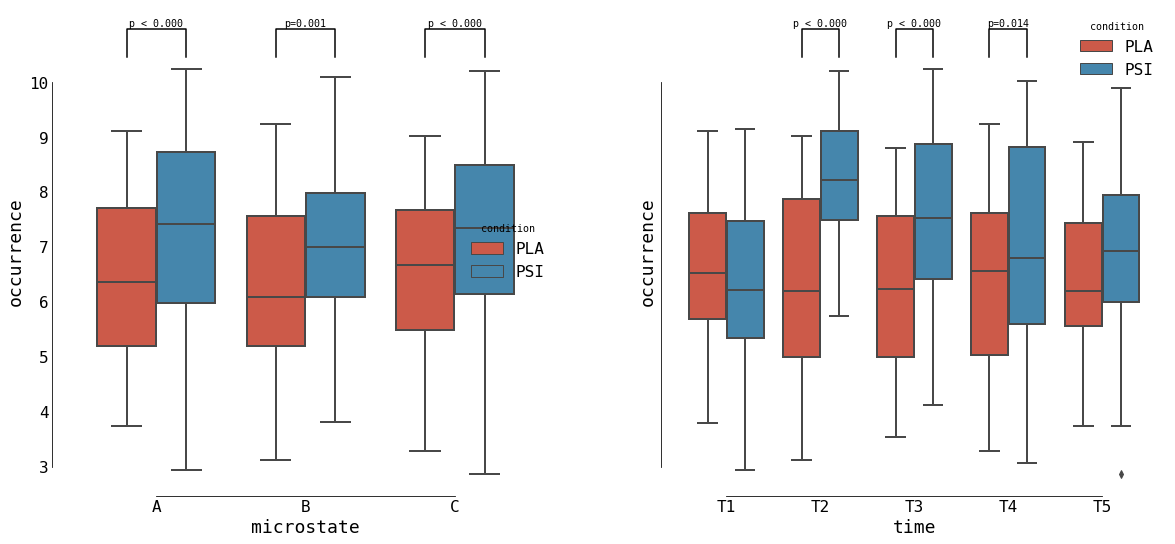

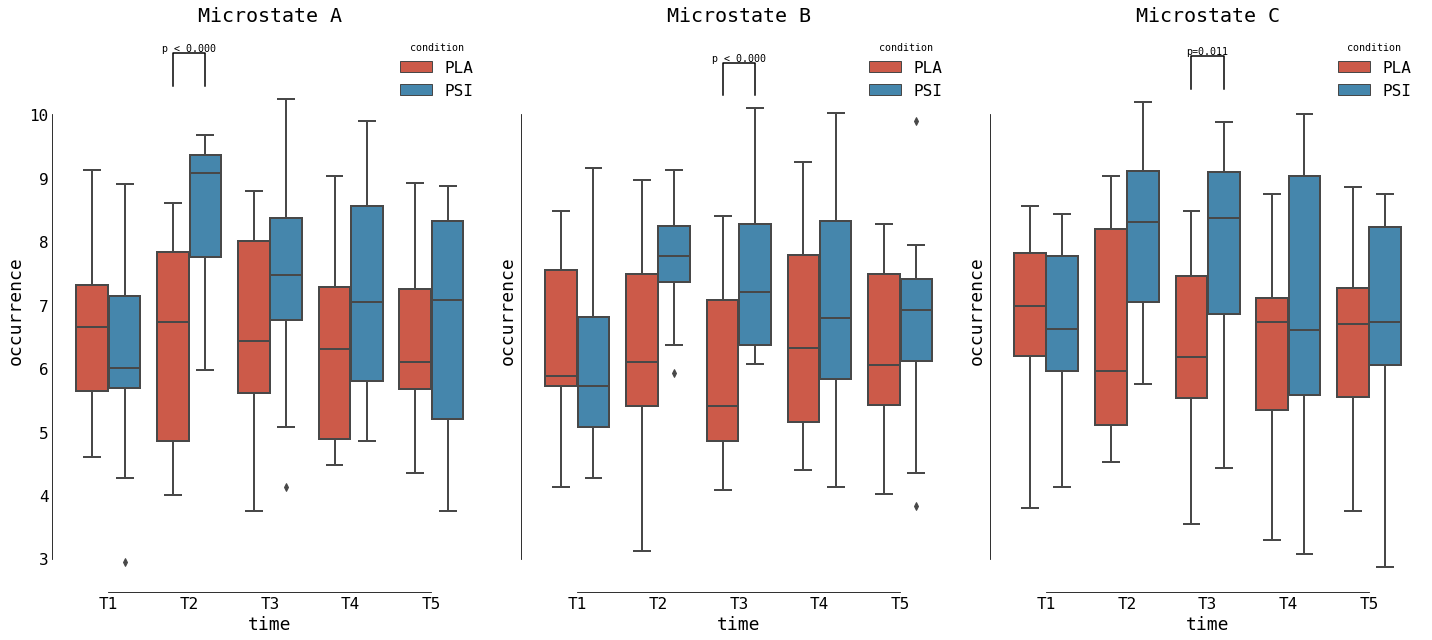

In [27]:
plot_boxes(df_140, "occurrence", "1-40")

### Differences between microstates

In [28]:
diff_between_microstates(df_140, "occurrence", filt_str="1-40")

Microstate differences: occurrence
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,2,447,0.977535,0.37704,0.004355


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,6.854331,6.650684,0.203647,0.184166,1.105780,0.533583,0.127684
1,A,C,6.854331,6.888994,-0.034663,0.184166,-0.188218,0.900000,-0.021734
2,B,C,6.650684,6.888994,-0.238310,0.184166,-1.293998,0.400159,-0.149418


Microstate differences w.r.t condition: occurrence


,Contrast,microstate,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
4,microstate * condition,A,PLA,PSI,True,True,-4.243558,74.0,two-sided,0.000063,0.000173,fdr_by,311.138,-0.482167
5,microstate * condition,B,PLA,PSI,True,True,-3.562748,74.0,two-sided,0.000646,0.001185,fdr_by,36.766,-0.450691
6,microstate * condition,C,PLA,PSI,True,True,-4.359468,74.0,two-sided,0.000041,0.000173,fdr_by,458.273,-0.513567


### Differences between time

In [29]:
diff_between_time(df_140, "occurrence", filt_str="1-40")

Time differences: occurrence
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,12.590010,4,56,3.147503,8.684977,0.000016,0.001144,0.382851,0.501842
1,condition,21.102130,1,14,21.102130,30.607568,0.000074,0.000074,0.686152,1.000000
2,time * condition,18.912531,4,56,4.728133,9.002373,0.000011,0.000240,0.391367,0.653012


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,6.456036,1.138978,7.276234,1.068435,True,True,-5.616779,14.0,two-sided,6.354530e-05,1.861222e-03,fdr_by,427.23,-0.742751
1,time,-,T1,T3,6.456036,1.138978,6.935434,1.213879,True,True,-4.300058,14.0,two-sided,7.334610e-04,1.074142e-02,fdr_by,50.53,-0.407296
6,time,-,T2,T5,7.276234,1.068435,6.567136,1.247195,True,True,3.447596,14.0,two-sided,3.923356e-03,3.830462e-02,fdr_by,12.122,0.610628
12,time * condition,T2,PLA,PSI,6.427706,1.633251,8.124762,1.235691,True,True,-6.398552,44.0,two-sided,8.748106e-08,4.993711e-07,fdr_by,1.642e+05,-1.171856
13,time * condition,T3,PLA,PSI,6.241613,1.507634,7.629255,1.497348,True,True,-6.513752,44.0,two-sided,5.920878e-08,4.993711e-07,fdr_by,2.372e+05,-0.923556
14,time * condition,T4,PLA,PSI,6.435483,1.519996,7.074865,1.806664,True,True,-3.073976,44.0,two-sided,3.620815e-03,1.377921e-02,fdr_by,9.429,-0.382979


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,6.456036,1.138978,7.276234,1.068435,True,True,-5.616779,14.0,two-sided,6.354530e-05,1.861222e-03,fdr_by,427.23,-0.742751
2,time,-,T1,T3,6.456036,1.138978,6.935434,1.213879,True,True,-4.300058,14.0,two-sided,7.334610e-04,1.074142e-02,fdr_by,50.53,-0.407296
7,time,-,T2,T5,7.276234,1.068435,6.567136,1.247195,True,True,3.447596,14.0,two-sided,3.923356e-03,3.830462e-02,fdr_by,12.122,0.610628
21,condition * time,PSI,T1,T2,6.339936,1.442407,8.124762,1.235691,True,True,-7.509367,44.0,two-sided,2.063535e-09,1.484812e-07,fdr_by,5.681e+06,-1.328952
22,condition * time,PSI,T1,T3,6.339936,1.442407,7.629255,1.497348,True,True,-6.856323,44.0,two-sided,1.857116e-08,6.681420e-07,fdr_by,7.085e+05,-0.877007
23,condition * time,PSI,T1,T4,6.339936,1.442407,7.074865,1.806664,True,True,-3.712323,44.0,two-sided,5.745770e-04,8.268714e-03,fdr_by,48.386,-0.449576
26,condition * time,PSI,T2,T4,8.124762,1.235691,7.074865,1.806664,True,True,3.650675,44.0,two-sided,6.909919e-04,8.286696e-03,fdr_by,40.999,0.678344
27,condition * time,PSI,T2,T5,8.124762,1.235691,6.696568,1.598984,True,True,4.775123,44.0,two-sided,2.018824e-05,4.842135e-04,fdr_by,1024.576,0.999485
29,condition * time,PSI,T3,T5,7.629255,1.497348,6.696568,1.598984,True,True,3.892157,44.0,two-sided,3.330437e-04,5.991023e-03,fdr_by,79.103,0.602122


### Significance of time / condition for each microstate

In [30]:
diff_between_time_and_microstates(df_140, "occurrence", filt_str="1-40")

Time differences: occurrence
----------
microstate A
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,19.627708,4,56,4.906927,7.154523,0.000100,0.000634,0.338203,0.728925
1,condition,22.654842,1,14,22.654842,28.441893,0.000106,0.000106,0.670137,1.000000
2,time * condition,25.159111,4,56,6.289778,6.202745,0.000333,0.001050,0.307025,0.797936


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,6.424373,1.27029,7.456772,1.220772,True,True,-5.321806,14.0,two-sided,0.000108,0.003158,fdr_by,268.209,-0.828719
12,time * condition,T2,PLA,PSI,6.381044,1.65069,8.532500,1.174227,True,True,-5.559942,14.0,two-sided,0.000070,0.000803,fdr_by,390.831,-1.501986


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,6.424373,1.270290,7.456772,1.220772,True,True,-5.321806,14.0,two-sided,0.000108,0.003158,fdr_by,268.209,-0.828719
21,condition * time,PSI,T1,T2,6.267721,1.627846,8.532500,1.174227,True,True,-5.206160,14.0,two-sided,0.000133,0.009576,fdr_by,222.961,-1.595728


----------
microstate B
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,10.646654,4,56,2.661663,4.018835,0.006184,0.019733,0.223035,0.624334
1,condition,16.596825,1,14,16.596825,17.454812,0.000930,0.000930,0.554917,1.000000
2,time * condition,20.991750,4,56,5.247937,4.705591,0.002409,0.006813,0.251561,0.733852


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
13,time * condition,T3,PLA,PSI,5.904423,1.419783,7.505934,1.277026,True,True,-5.563564,14.0,two-sided,0.00007,0.000797,fdr_by,393.059,-1.186047


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,11.754979,4,56,2.938745,2.851953,0.031929,0.051454,0.169236,0.716591
1,condition,24.477619,1,14,24.477619,14.489169,0.001926,0.001926,0.508585,1.000000
2,time * condition,17.855321,4,56,4.463830,4.646156,0.002612,0.008380,0.249175,0.696381


Pairwise 'time x condition' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
13,time * condition,T3,PLA,PSI,6.217726,1.451288,7.942558,1.619103,True,True,-4.158625,14.0,two-sided,0.000965,0.011019,fdr_by,39.902,-1.121851


Pairwise 'condition x time' t-tests (showing only significant after FDR_BY correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
22,condition * time,PSI,T1,T3,6.704345,1.294443,7.942558,1.619103,True,True,-4.929712,14.0,two-sided,0.000222,0.01595,fdr_by,142.671,-0.844741
